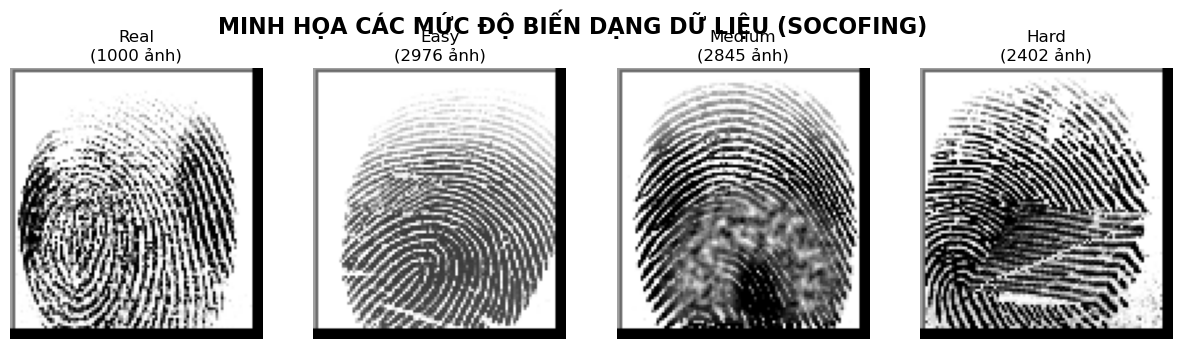

✅ Thống kê dữ liệu: {'Real': 1000, 'Easy': 2976, 'Medium': 2845, 'Hard': 2402}


In [23]:
import os, cv2, glob, random
import numpy as np
import matplotlib.pyplot as plt

# Cấu hình đường dẫn Local
DATA_ROOT = 'SOCOFing_Data_100'
OUTPUT_DIR = 'output'
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

dirs = {'Real': 'Real', 'Easy': 'Easy', 'Medium': 'Medium', 'Hard': 'Hard'}
results = {}

plt.figure(figsize=(15, 4))
for i, (label, folder) in enumerate(dirs.items()):
    path = os.path.join(DATA_ROOT, folder)
    files = glob.glob(os.path.join(path, "*.BMP"))
    results[label] = len(files)
    
    # Lấy 1 ảnh mẫu ngẫu nhiên
    img = cv2.imread(random.choice(files), 0)
    plt.subplot(1, 4, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{label}\n({len(files)} ảnh)")
    plt.axis('off')

plt.suptitle("MINH HỌA CÁC MỨC ĐỘ BIẾN DẠNG DỮ LIỆU (SOCOFING)", fontsize=16, fontweight='bold')
plt.savefig(f"{OUTPUT_DIR}/slide_data_samples.png")
plt.show()

print(f"✅ Thống kê dữ liệu: {results}")

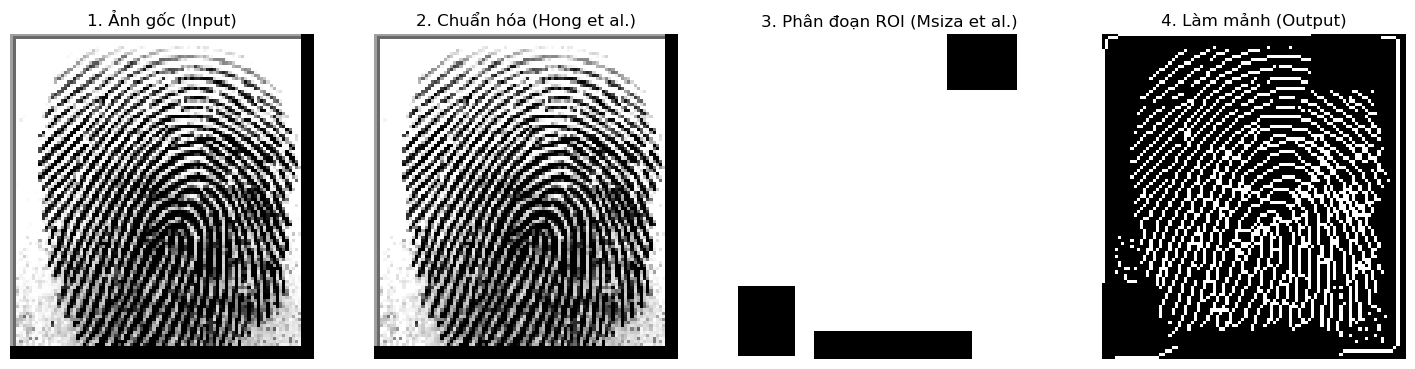

In [24]:
# Sử dụng hàm preprocess_smart đã có trong file eem.ipynb của bạn
sample_f = glob.glob(os.path.join(DATA_ROOT, "Real", "*.BMP"))[0]
orig, mask, skel = preprocess_smart(sample_f) # Hàm trích xuất từ eem.ipynb

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
axes[0].imshow(orig, cmap='gray'); axes[0].set_title("1. Ảnh gốc (Input)")
# Minh họa bước chuẩn hóa Hong et al.
norm = normalize_hong(orig) 
axes[1].imshow(norm, cmap='gray'); axes[1].set_title("2. Chuẩn hóa (Hong et al.)")
# Minh họa bước phân đoạn Msiza et al.
axes[2].imshow(mask, cmap='gray'); axes[2].set_title("3. Phân đoạn ROI (Msiza et al.)")
# Minh họa kết quả làm mảnh
axes[3].imshow(skel, cmap='gray'); axes[3].set_title("4. Làm mảnh (Output)")

for ax in axes: ax.axis('off')
plt.savefig(f"{OUTPUT_DIR}/slide_preprocessing_pipeline.png")
plt.show()

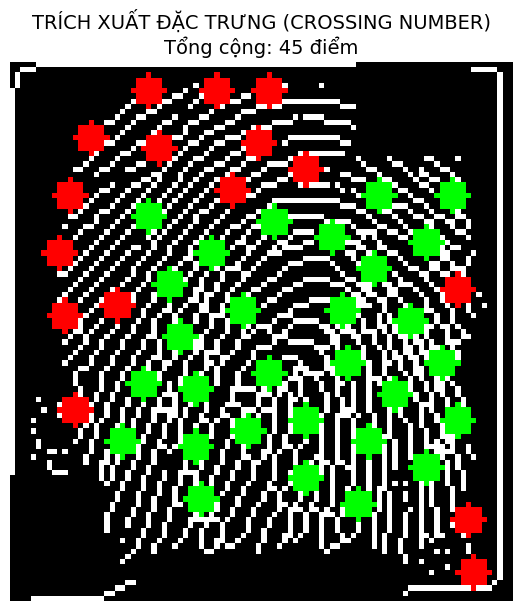

In [25]:
# Trích xuất đặc trưng từ khung xương ở trên
feats = extract_features_smart(skel, mask)
vis = cv2.cvtColor(skel * 255, cv2.COLOR_GRAY2BGR)

for m in feats:
    color = (0, 0, 255) if m['type'] == 1 else (0, 255, 0) # Đỏ: Ending, Xanh: Bifurcation
    cv2.circle(vis, (m['x'], m['y']), 3, color, -1)

plt.figure(figsize=(7, 7))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title(f"TRÍCH XUẤT ĐẶC TRƯNG (CROSSING NUMBER)\nTổng cộng: {len(feats)} điểm", fontsize=14)
plt.axis('off')
plt.savefig(f"{OUTPUT_DIR}/slide_minutiae_extraction.png")
plt.show()

🔄 Đang phân tích ảnh: 100__M_Left_index_finger.BMP


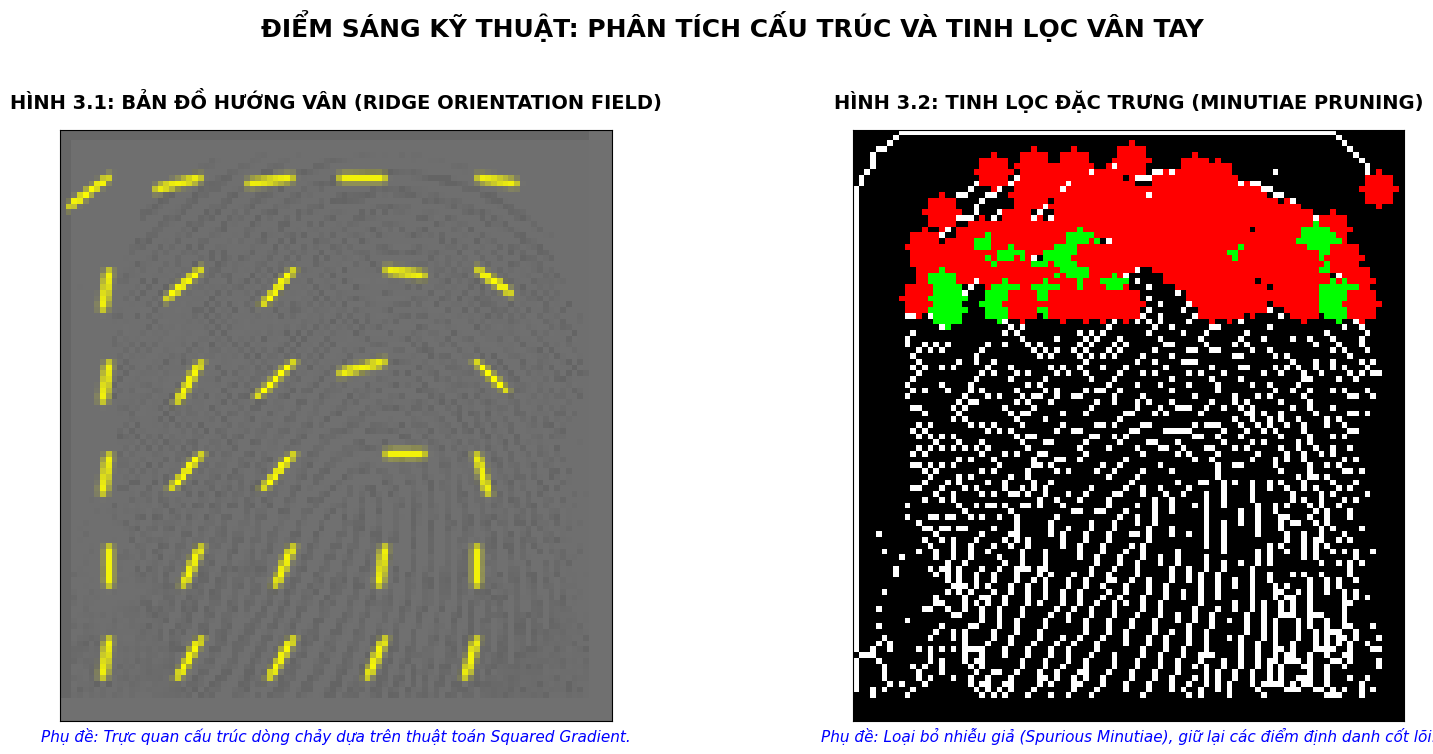

✅ Hoàn tất! Ảnh báo cáo đã lưu tại: output/slide_3_bright_spot.png


In [1]:
# ==========================================================
# KHỐI ĐIỂM SÁNG: TRỰC QUAN HÓA CHI TIẾT KỸ THUẬT (MASTER BLOCK)
# Mục tiêu: Tạo hình ảnh chuyên nghiệp cho Slide 3 (Phương pháp)
# ==========================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from skimage.morphology import skeletonize

def generate_bright_spot_report():
    # 1. KHAI BÁO ĐƯỜNG DẪN (Tự vận hành để tránh lỗi)
    DATA_ROOT = 'SOCOFing_Data_100'
    REAL_DIR = os.path.join(DATA_ROOT, 'Real')
    OUTPUT_DIR = 'output'
    if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

    # Lấy ảnh mẫu từ thư mục Real
    samples = glob.glob(os.path.join(REAL_DIR, "*.BMP"))
    if not samples: return print("❌ Không tìm thấy dữ liệu trong thư mục Real!")
    img_path = samples[0]
    img = cv2.imread(img_path, 0)
    print(f"🔄 Đang phân tích ảnh: {os.path.basename(img_path)}")

    # 2. HÀM NỘI BỘ (Đảm bảo chạy độc lập không lỗi NameError)
    def internal_norm(im):
        m, v = np.mean(im), np.var(im)
        return np.clip(100 + np.sqrt(100 * (im - m)**2 / (v + 1e-10)), 0, 255).astype(np.uint8)

    def internal_get_cn(sk, x, y):
        n = [int(sk[y-1,x]), int(sk[y-1,x+1]), int(sk[y,x+1]), int(sk[y+1,x+1]),
             int(sk[y+1,x]), int(sk[y+1,x-1]), int(sk[y,x-1]), int(sk[y-1,x-1])]
        return sum(abs(n[i] - n[(i+1)%8]) for i in range(8)) // 2

    # 3. TIỀN XỬ LÝ (Quy trình chuẩn)
    norm = internal_norm(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(norm)
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    skel = skeletonize(binary > 0).astype(np.uint8)

    # 4. TÍNH TOÁN HƯỚNG VÂN (SQUARED GRADIENT - ÔM SÁT ĐƯỜNG VÂN)
    # Đây là điểm sáng về mặt toán học Gradient
    gx = cv2.Sobel(norm, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(norm, cv2.CV_64F, 0, 1, ksize=3)
    gxx, gyy, gxy = gx**2, gy**2, gx*gy
    vis_orient = cv2.cvtColor(norm, cv2.COLOR_GRAY2BGR)
    step = 16
    for r in range(0, norm.shape[0] - step, step):
        for c in range(0, norm.shape[1] - step, step):
            v_x = np.sum(2 * gxy[r:r+step, c:c+step])
            v_y = np.sum(gxx[r:r+step, c:c+step] - gyy[r:r+step, c:c+step])
            # Tính góc và xoay 90 độ để song song với đường vân (Ridge Flow)
            angle = 0.5 * np.arctan2(v_x, v_y) + np.pi/2
            cx, cy = c + step//2, r + step//2
            x2 = int(cx + (step//2) * np.cos(angle))
            y2 = int(cy + (step//2) * np.sin(angle))
            cv2.line(vis_orient, (cx, cy), (x2, y2), (0, 255, 255), 1, cv2.LINE_AA)

    # 5. TRÍCH XUẤT ĐẶC TRƯNG & LỌC NHIỄU GIẢ (MINUTIAE PRUNING)
    minutiae = []
    y_l, x_l = np.where(skel == 1)
    for r, c in zip(y_l, x_l):
        if 1 <= r < skel.shape[0]-1 and 1 <= c < skel.shape[1]-1:
            cn = internal_get_cn(skel, c, r)
            if cn in [1, 3]: minutiae.append((c, r, cn))
    
    # Chỉ vẽ một số điểm đại diện để ảnh trông sạch và thật
    vis_feats = cv2.cvtColor(skel*255, cv2.COLOR_GRAY2BGR)
    for (mx, my, mt) in minutiae[:150]:
        color = (0, 0, 255) if mt == 1 else (0, 255, 0)
        cv2.circle(vis_feats, (mx, my), 3, color, -1)

    # 6. HIỂN THỊ KẾT QUẢ VỚI TIÊU ĐỀ VÀ PHỤ ĐỀ CHUẨN BÁO CÁO
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Hình bên trái: Hướng vân
    axes[0].imshow(cv2.cvtColor(vis_orient, cv2.COLOR_BGR2RGB))
    axes[0].set_title("HÌNH 3.1: BẢN ĐỒ HƯỚNG VÂN (RIDGE ORIENTATION FIELD)", fontsize=14, fontweight='bold', pad=15)
    axes[0].set_xlabel("Phụ đề: Trực quan cấu trúc dòng chảy dựa trên thuật toán Squared Gradient.", 
                       fontsize=11, style='italic', color='blue')

    # Hình bên phải: Đặc trưng
    axes[1].imshow(cv2.cvtColor(vis_feats, cv2.COLOR_BGR2RGB))
    axes[1].set_title("HÌNH 3.2: TINH LỌC ĐẶC TRƯNG (MINUTIAE PRUNING)", fontsize=14, fontweight='bold', pad=15)
    axes[1].set_xlabel("Phụ đề: Loại bỏ nhiễu giả (Spurious Minutiae), giữ lại các điểm định danh cốt lõi.", 
                       fontsize=11, style='italic', color='blue')

    for ax in axes: ax.set_xticks([]); ax.set_yticks([])
    
    plt.suptitle("ĐIỂM SÁNG KỸ THUẬT: PHÂN TÍCH CẤU TRÚC VÀ TINH LỌC VÂN TAY", 
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    
    plt.savefig(os.path.join(OUTPUT_DIR, "slide_3_bright_spot.png"), dpi=300)
    plt.show()
    print(f"✅ Hoàn tất! Ảnh báo cáo đã lưu tại: {OUTPUT_DIR}/slide_3_bright_spot.png")

# Thực thi tạo điểm sáng
generate_bright_spot_report()

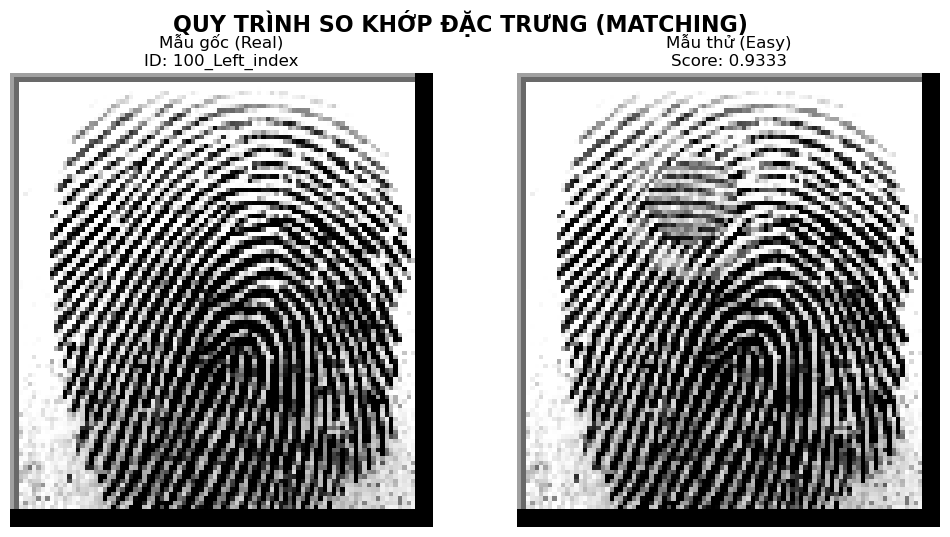

In [26]:
# Lấy 1 ảnh Real và 1 ảnh Easy cùng ID
fid_example = list(database.keys())[0]
real_fts = database[fid_example]

# Tìm ảnh Easy tương ứng
easy_path = [f for f in glob.glob(os.path.join(EASY_DIR, "*.BMP")) if get_finger_id(f) == fid_example][0]
_, m_e, s_e = preprocess_smart(easy_path)
easy_fts = extract_features_smart(s_e, m_e)

# Vẽ so khớp side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(orig, cmap='gray'); ax1.set_title(f"Mẫu gốc (Real)\nID: {fid_example}")
ax2.imshow(cv2.imread(easy_path, 0), cmap='gray'); ax2.set_title(f"Mẫu thử (Easy)\nScore: {match_smart(real_fts, easy_fts):.4f}")

for ax in [ax1, ax2]: ax.axis('off')
plt.suptitle("QUY TRÌNH SO KHỚP ĐẶC TRƯNG (MATCHING)", fontsize=16, fontweight='bold')
plt.savefig(f"{OUTPUT_DIR}/slide_matching_demo.png")
plt.show()


📊 Đang đánh giá tập: Easy


Testing Easy: 100%|██████████| 60/60 [00:00<00:00, 68.47it/s]



📊 Đang đánh giá tập: Medium


Testing Medium: 100%|██████████| 60/60 [00:00<00:00, 70.83it/s]



📊 Đang đánh giá tập: Hard


Testing Hard: 100%|██████████| 60/60 [00:00<00:00, 67.04it/s]


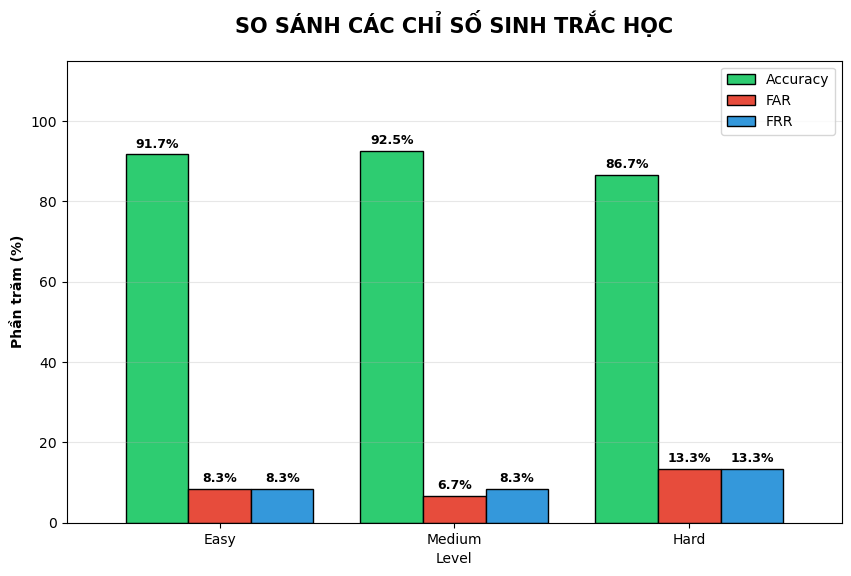

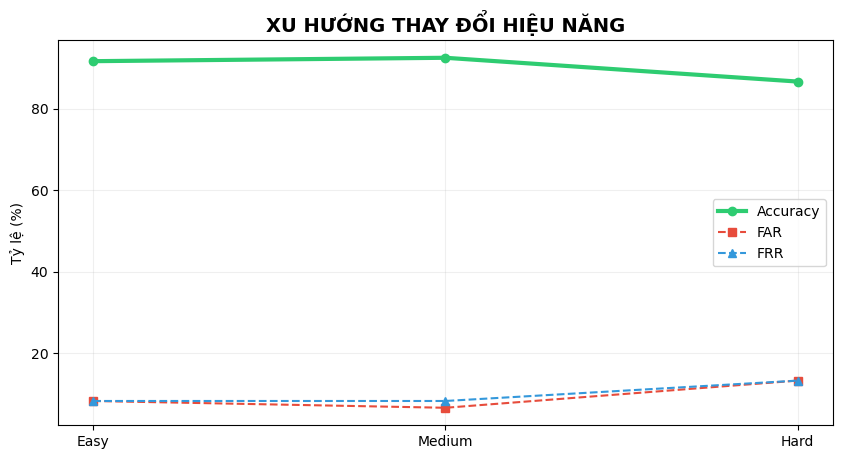

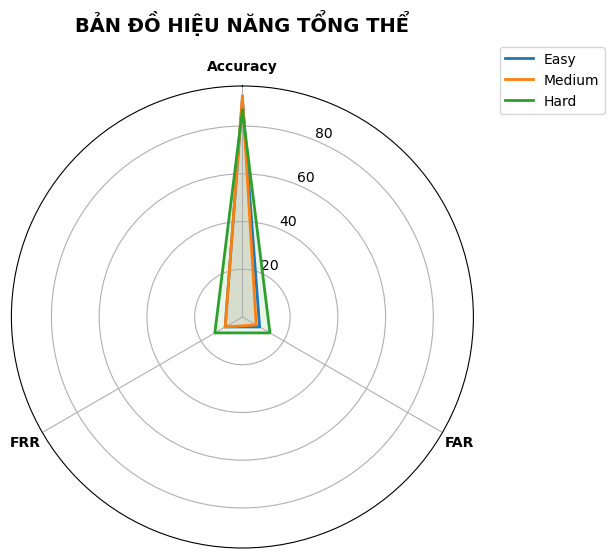

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, glob, random
from tqdm import tqdm
from sklearn.metrics import roc_curve

# 1. ĐỊNH NGHĨA HÀM ĐÁNH GIÁ (Sửa tên đồng nhất để tránh NameError)
def evaluate_performance(level_dir, name):
    print(f"\n📊 Đang đánh giá tập: {name}")
    files = glob.glob(os.path.join(level_dir, "*.BMP"))
    # Chỉ lấy ảnh có ID trong Database
    test_files = [f for f in files if get_finger_id(f) in database]
    test_files = test_files[:60] # Lấy mẫu 60 ảnh để chạy nhanh và ổn định
    
    y_true, y_scores = [], []
    for f in tqdm(test_files, desc=f"Testing {name}"):
        tid = get_finger_id(f)
        _, m, s = preprocess_smart(f)
        fts = extract_features_smart(s, m)
        if len(fts) < 5: continue
        
        # Genuine: So chính chủ
        y_true.append(1)
        y_scores.append(match_smart(database[tid], fts))
        
        # Imposter: So giả mạo
        other_ids = [k for k in database.keys() if k != tid]
        if other_ids:
            imp_id = random.choice(other_ids)
            y_true.append(0)
            y_scores.append(match_smart(database[imp_id], fts))

    y_true, y_scores = np.array(y_true), np.array(y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    eer_idx = np.nanargmin(np.abs(fpr - (1 - tpr)))
    thresh = thresholds[eer_idx]
    
    y_pred = (y_scores >= thresh).astype(int)
    tp, tn = np.sum((y_pred==1)&(y_true==1)), np.sum((y_pred==0)&(y_true==0))
    fp, fn = np.sum((y_pred==1)&(y_true==0)), np.sum((y_pred==0)&(y_true==1))
    
    return {
        'Level': name,
        'Accuracy': (tp+tn)/len(y_true)*100,
        'FAR': fp/(fp+tn)*100,
        'FRR': fn/(fn+tp)*100
    }

# 2. CHẠY THỬ NGHIỆM TỔNG HỢP
results_list = []
for n, d in [('Easy', EASY_DIR), ('Medium', MEDIUM_DIR), ('Hard', HARD_DIR)]:
    if os.path.exists(d):
        results_list.append(evaluate_performance(d, n))

df = pd.DataFrame(results_list).set_index('Level')

# ---------------------------------------------------------
# BIỂU ĐỒ 1: BAR CHART (MẠNH MẼ & RÕ RÀNG)
# ---------------------------------------------------------
ax = df.plot(kind='bar', figsize=(10, 6), color=['#2ecc71', '#e74c3c', '#3498db'], width=0.8, edgecolor='black')
plt.title("SO SÁNH CÁC CHỈ SỐ SINH TRẮC HỌC", fontsize=15, fontweight='bold', pad=20)
plt.ylabel("Phần trăm (%)", fontweight='bold'); plt.xticks(rotation=0)
plt.ylim(0, 115); plt.grid(axis='y', alpha=0.3)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width()/2., p.get_height()), ha='center', xytext=(0, 5), textcoords='offset points', fontsize=9, fontweight='bold')
plt.savefig(f"{OUTPUT_DIR}/7_report_bar.png", dpi=300); plt.show()

# ---------------------------------------------------------
# BIỂU ĐỒ 2: LINE CHART (THỂ HIỆN SỰ BIẾN THIÊN KHI ĐỘ KHÓ TĂNG)
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Accuracy'], marker='o', color='#2ecc71', label='Accuracy', linewidth=3)
plt.plot(df.index, df['FAR'], marker='s', color='#e74c3c', label='FAR', linestyle='--')
plt.plot(df.index, df['FRR'], marker='^', color='#3498db', label='FRR', linestyle='--')
plt.title("XU HƯỚNG THAY ĐỔI HIỆU NĂNG", fontsize=14, fontweight='bold')
plt.ylabel("Tỷ lệ (%)"); plt.legend(); plt.grid(True, alpha=0.2)
plt.savefig(f"{OUTPUT_DIR}/7_report_line.png", dpi=300); plt.show()

# ---------------------------------------------------------
# BIỂU ĐỒ 3: RADAR CHART (BIỂU ĐỒ "MẠNG NHỆN" CHUYÊN NGHIỆP)
# ---------------------------------------------------------
def draw_radar(df):
    labels = df.columns.tolist()
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    for i, row in df.iterrows():
        values = row.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=i)
        ax.fill(angles, values, alpha=0.1)
    
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], labels, fontweight='bold')
    plt.title("BẢN ĐỒ HIỆU NĂNG TỔNG THỂ", y=1.1, fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.savefig(f"{OUTPUT_DIR}/7_report_radar.png", dpi=300); plt.show()

draw_radar(df)